In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

def calculate_pde_eigenvalues(m, n):
    return np.sqrt(scipy.special.jn_zeros(m, n + 1)[-1]**2 / 2)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]

def style_plot(fig, ax, aspect="equal", label_fontsize=20, no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect == "equal":
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels(minor=True) + ax.get_yticklabels(minor=True):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    for label in (ax.get_xticklabels(minor=False) + ax.get_yticklabels(minor=False)):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

def generate_guesses(x, num_Vs):
    guesses = []
    for i in x:  
        if np.abs(i) < 1e-15:
            guesses.append(np.array([1e-15]))
        else:
            if num_Vs < 2000:
                guesses.append(np.linspace(0.8 * i, i + 0.2, 80))
            else:
                guesses.append(np.linspace(0.93 * i, i + 0.02, 60))
                
    return np.concatenate(guesses)

In [2]:
nums_Vs = np.array(10**np.linspace(2, 4, 12)).astype(int)
nums_Vs = np.concatenate([nums_Vs, [100000]])
print(nums_Vs)

[   100    151    231    351    533    811   1232   1873   2848   4328
   6579  10000 100000]


In [27]:
eigenvalues = {}

for num_Vs in nums_Vs:

    print(num_Vs)

    eigenvalues[num_Vs] = {}

    if num_Vs < 1000:
        max_seeds = 128
        guess = 1.3
        num_guesses = 5
        printerval = np.inf
    elif num_Vs < 5000:
        max_seeds = 64
        guess = 1.5
        num_guesses = 3
        printerval = 10
    elif num_Vs < 10001: 
        max_seeds = 16
        guess = 1.6
        num_guesses = 1
        printerval = 1
    else:
        max_seeds = 8
        guess = 1.64
        num_guesses = 1
        printerval = 1

    for seed in range(max_seeds):
        np.random.seed(seed)
        # Construct graph
        g = construct_graph.random_delaunay_disc.Random_Delaunay_Disc(num_Vs, fix_boundary=True, auto_plot=False)
        # Calculate eigenvalues
        guesses = np.linspace(guess, 1.64, num_guesses)
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=printerval, max_steps=1000, tol=1e-12, solve_type="SVD iterate", num_vectors=20)
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues[num_Vs][seed] = ks[index]

    print("\n\n\n")

100




151




231




351




533




811




1232

Calculating eig number 0

----------------------
Converged at step 5:

k = 1.6390860761818495
----------------------

Calculating eig number 1

----------------------
Converged at step 4:

k = 1.6390860761818542
----------------------

Calculating eig number 2

----------------------
Converged at step 4:

k = 1.6390860761818502
----------------------

Calculating eig number 0

----------------------
Converged at step 5:

k = 1.6416761686763512
----------------------

Calculating eig number 1

----------------------
Converged at step 4:

k = 1.641676168676351
----------------------

Calculating eig number 2

----------------------
Converged at step 3:

k = 1.6416761686763526
----------------------

Calculating eig number 0

----------------------
Converged at step 4:

k = 1.630049366805676
----------------------

Calculating eig number 1

----------------------
Converged at step 4:

k = 1.6300493668056784
----------------------

Calc

In [21]:
c = 0.9594902707114124

In [22]:
cleaned_eigenvalues = {}

for num_Vs in eigenvalues:
    cleaned_eigenvalues[num_Vs] = []
    for seed in eigenvalues[num_Vs]:
        cleaned_eigenvalues[num_Vs].append(eigenvalues[num_Vs][seed][0])

In [23]:
mean_difs = []
std_difs = []

for num_Vs in nums_Vs:
    
    data_eigs = np.mean(cleaned_eigenvalues[num_Vs])

    continuum_eig = c * calculate_pde_eigenvalues(0, 0)
    difs = np.abs((data_eigs - continuum_eig) / continuum_eig)

    mean_difs.append(np.mean(difs))
    std_difs.append(np.std(difs))

In [24]:
def plot_loglog_rel_err(Num_Vs, rel_errs, plot_order_line=True, show_legend=False, rate_slope=0.5, rate_scaling=1):
    

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111)

    # Separate data by size
    for en, rel_err in enumerate(rel_errs):
        ax.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])

    if plot_order_line:
        # Setup convergence line
        order_line_data =  Num_Vs**(-0.5)
        ax.loglog(Num_Vs, order_line_data, 
                linewidth=4, c='r')

    style_plot(fig, ax, aspect=None, no_xticks=True)

    return fig, fig.axes

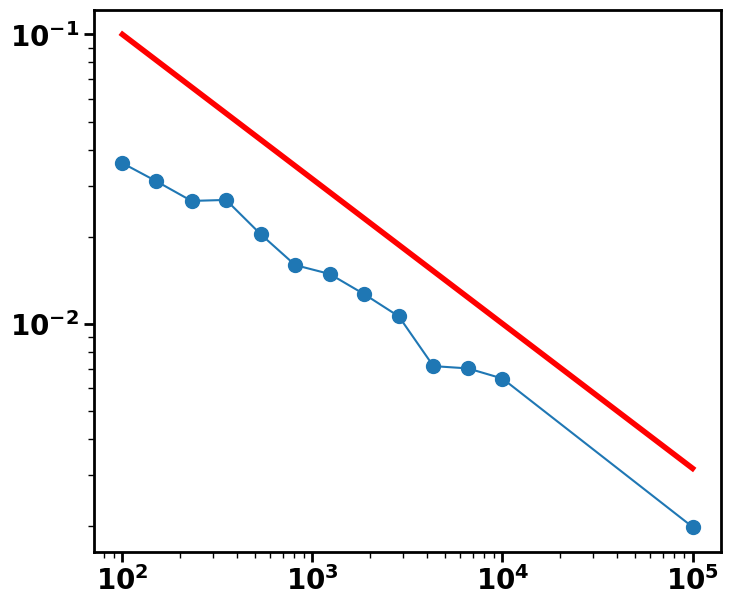

In [26]:
fig, ax = plot_loglog_rel_err(nums_Vs, [np.array(mean_difs)])
ax = ax[0]
ax.tick_params(axis='x', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='x', which='minor', length=4, width=1, direction='out')
ax.tick_params(axis='y', which='minor', length=4, width=1, direction='out')

save_file_name = ("/Users/sidneyholden/repos/metric_graph/data/random_delaunay_disc" + 
                  "/uniform_delaunay_disc_eigenvalue_relerr.png")

plt.savefig(save_file_name, dpi=200, bbox_inches='tight')

## Eigenfunction calculations

In [11]:
# file = open("uniform_delaunay_disc_boundary_fixed_eigenfunction_relerr.pkl", "wb")
# pickle.dump(efunc_rel_errs, file)
# file.close()

# file = open("uniform_delaunay_disc_boundary_fixed_eigenvalue_relerr.pkl", "rb")
# eigenvalues = pickle.load(file)
# file.close()

In [4]:
Eigenvalues = {}
for num_Vs in eigenvalues:
    Eigenvalues[num_Vs] = []
    for seed in eigenvalues[num_Vs]:
        Eigenvalues[num_Vs].append(eigenvalues[num_Vs][seed])

In [7]:
efunc_rel_errs = {}

continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("disc")

for num_Vs in nums_Vs:

    print(num_Vs)

    efunc_rel_errs[num_Vs] = []

    for seed, eigenvalue in enumerate(Eigenvalues[num_Vs]):
        if num_Vs > 2000:
            print(seed)
        np.random.seed(seed)
        g = construct_graph.random_delaunay_disc.Random_Delaunay_Disc(num_Vs, fix_boundary=True, auto_plot=False)
        p = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalue, continuum_eigendata)
        full_data = {}
        p(0, 1)
        full_data[g.num_Vs] = p.data
        edata = solve_laplace_operator.solve_laplace_operator.Eigendata(full_data)
        efunc_rel_errs[num_Vs].append(edata.relative_eigenfunction_differences[0, 1][0])

100
151
231
351
533
811
1232
1873
2848
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
4328
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
6579
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
10000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
100000
0


KeyboardInterrupt: 

In [8]:
efunc_rel_errs

{100: [0.10278940890786215,
  0.12788556595659775,
  0.08015526261577664,
  0.08201300087914339,
  0.12580788298539547,
  0.12468649654872364,
  0.11130970088509681,
  0.0968869345863483,
  0.09524689570354225,
  0.08420482699797875,
  0.1185595293032252,
  0.24527822858167925,
  0.08723681672870276,
  0.10100667311824851,
  0.11328363197874342,
  0.10375508823904882,
  0.12136039241615745,
  0.07780525756125486,
  0.11574381862426869,
  0.09672829027133284,
  0.08662814000292518,
  0.14542656469522985,
  0.0893406561207924,
  0.11028015746268599,
  0.08129564165917755,
  0.08233189764905355,
  0.12180083250794393,
  0.08597734873617686,
  0.09122517452060945,
  0.1201294165455283,
  0.06334953140321845,
  0.11807654546528586,
  0.13734043815877528,
  0.10490829493738726,
  0.10151575598514231,
  0.15226079396638065,
  0.09983184928005946,
  0.13595517602199017,
  0.10901390896642346,
  0.11465923573651016,
  0.10755205491211697,
  0.07594739537569574,
  0.0995945136278946,
  0.1252435

In [9]:
efunc_rel_errs[100000].pop()

[]

In [14]:
mean_difs = []

for num_Vs in nums_Vs[:-1]:
    
    data_eigs = np.mean(efunc_rel_errs[num_Vs])

    mean_difs.append(np.mean(data_eigs))

In [15]:
def plot_loglog_rel_err(Num_Vs, rel_errs, plot_order_line=True, show_legend=False, rate_slope=1, rate_scaling=1):
    

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111)

    # Separate data by size
    for en, rel_err in enumerate(rel_errs):
        ax.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])

    if plot_order_line:
        # Setup convergence line
        order_line_data = Num_Vs**(-0.5) * 3
        ax.loglog(Num_Vs, order_line_data, 
                linewidth=4, c='r')

    style_plot(fig, ax, aspect=None, no_xticks=True)

    return fig, fig.axes

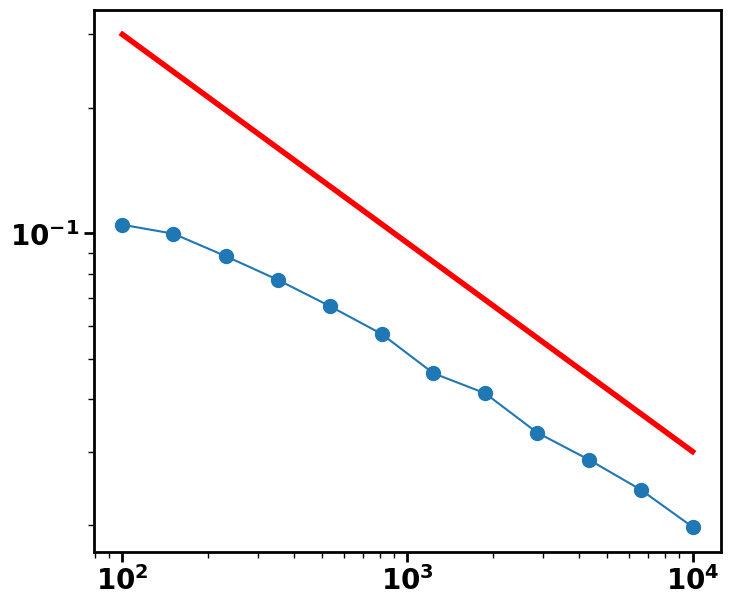

In [17]:
fig, ax = plot_loglog_rel_err(nums_Vs[:-1], np.array([mean_difs]), plot_order_line=True)
ax = ax[0]
ax.tick_params(axis='x', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='x', which='minor', length=4, width=1, direction='out')
ax.tick_params(axis='y', which='minor', length=4, width=1, direction='out')

save_file_name = ("/Users/sidneyholden/repos/metric_graph/data/random_delaunay_disc" + 
                  "/uniform_delaunay_disc_eigenfunction_relerr.png")

plt.savefig(save_file_name, dpi=200, bbox_inches='tight')